## Fune-tune the System -SGD Classifier

#### 0. Import modules and define parameters

In [18]:
import sys
sys.path.append("..")

from module.utils import general_utils
from module.utils import data_prepare_utils
import module.utils.bin_class_utils as bin_class_utils

from sklearn.pipeline import Pipeline
import time
import numpy as np

In [2]:
TRAIN_FILE_PATH = "../data/train_df.csv"
VALIDATION_FILE_PATH = "../data/validation_df.csv"

TARGET_ATTR = "label"
TARGET_TYPE = "binary"

ESTIMATOR_NAME = "SGDClassifier"

SAMPLE_SIZE = 0.05
SAMPLE_RANDOM_STATE = 24
TARGET_ENCODING_RANDOM_STATE = 42
MODEL_RANDOM_STATE = 42
PERMUTATION_IMPORTANCE_RANDOM_STATE = 0

ATTRS_TO_DROP = ['app_score',
                 'device_size',
                 'indu_name',
                 'uid',
                 'emui_dev',
                 'tags',
                 'his_on_shelf_time',
                 'spread_app_id',
                 'communication_onlinerate',
                 'consume_purchase',
                 'task_id',
                 'device_name',
                 'creat_type_cd',
                 'dev_id',
                 'residence',
                 'city_rank']

CVS_SCORING_LIST = ['accuracy', 'precision', 'recall', 'recall', 'f1']
PERMUTATION_SCORING_LIST = ['average_precision', 'roc_auc']

#### 1. Import data and identify attributes

In [3]:
train_df = general_utils.read_csv(TRAIN_FILE_PATH)


Read CSV file ../data/train_df.csv into DataFrame:
df.head(): 


,uid,task_id,adv_id,creat_type_cd,adv_prim_id,dev_id,inter_type_cd,slot_id,spread_app_id,tags,...,device_price,up_life_duration,up_membership_grade,membership_life_duration,consume_purchase,communication_onlinerate,communication_avgonline_30d,indu_name,pt_d,label
0,1920544,3854,3367,7,207,17,5,11,13,37,...,4,20,-1,-1,2,7^8^9^10^11^12^13^14^15^16^17^18^19^20^21^22^23,10,17,6,0
1,1850503,3903,6370,7,173,52,5,12,69,11,...,2,-1,-1,-1,2,5^6^7^8^9^10^11^12^13^14^15^16^17^18^19^20^21^...,12,50,7,0
2,2157496,1847,6428,6,178,17,5,18,70,39,...,7,20,1,-1,9,0^1^2^3^4^5^6^7^8^9^10^11^12^13^14^15^16^17^18...,13,36,7,0
3,2072043,4125,4468,7,168,37,5,12,44,40,...,2,20,-1,-1,2,6^7^8^9^10^11^12^13^14^15^16^17^18^19^20^21^22^23,11,17,6,0
4,1084626,4811,3326,7,183,29,5,12,86,37,...,3,18,-1,-1,2,7^8^9^10^11^12^13^14^15^16^17^18^19^20^21^22^23,10,17,6,0


df.shape: (670513, 36)


In [4]:
train_df_sample = data_prepare_utils.sample_data(train_df, SAMPLE_SIZE, SAMPLE_RANDOM_STATE)
del train_df


Sample 0.05 fraction from DataFrame:
sample_df.shape: (33525, 36)


In [5]:
train_cap_x_df, train_y_df = train_df_sample.drop(columns=TARGET_ATTR), train_df_sample[[TARGET_ATTR]]

In [6]:
numerical_attr_list = []
categorical_attr_list = [attr for attr in train_cap_x_df.columns if attr not in numerical_attr_list and attr != TARGET_ATTR]
attr_list = numerical_attr_list + categorical_attr_list

#### 2. Build composite estimator

In [7]:
preprocessor = bin_class_utils.build_preprocessing_pipeline(numerical_attr_list, categorical_attr_list, ATTRS_TO_DROP, TARGET_TYPE, TARGET_ENCODING_RANDOM_STATE)
estimator = bin_class_utils.get_default_model(ESTIMATOR_NAME, MODEL_RANDOM_STATE)

In [8]:
composite_estimator = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('estimator', estimator)
])

#### 3. Design grid search and tune hyperparameters of composite estimator

In [9]:
best_model = bin_class_utils.tune_hyperparameters_sgd(train_cap_x_df, train_y_df, composite_estimator)

Best estimator: {'estimator__alpha': 0.0001, 'estimator__l1_ratio': 0.5, 'estimator__loss': 'log_loss', 'estimator__max_iter': 1000, 'estimator__n_jobs': None, 'estimator__penalty': 'elasticnet', 'preprocessor__categorical__target_encoder__smooth': 'auto', 'preprocessor__numerical__imputer__strategy': 'mean'}


#### 4. Evaluate hyperparameter-tuned estimator on train set

Evaluate the trained estimator performance on train sample set
Check accuracy score
train sample set accuracy score: 0.5937658463832961

Check classification report
              precision    recall  f1-score   support

           0       0.98      0.59      0.74     32369
           1       0.05      0.66      0.10      1156

    accuracy                           0.59     33525
   macro avg       0.52      0.62      0.42     33525
weighted avg       0.95      0.59      0.72     33525


Check confusion matrix
train sample set confusion matrix: 
[[19148 13221]
 [  398   758]]
True Positives =  19148
True Negatives =  758
False Positives(Type I error) =  13221
False Negatives(Type II error) =  398

Check cross validation score

accuracy scores: [0.74780015 0.69381059 0.72050708 0.73810589 0.71290082]
np.mean(scores): 0.7226249067859806
np.std(scores, ddof=1): 0.021229470302881324

precision scores: [0.06650831 0.05123153 0.06649077 0.05642816 0.06611994]
np.mean(scores): 0.0613557400403

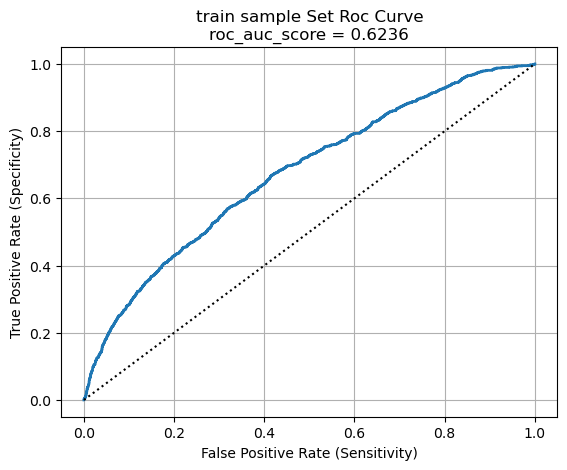


Check Precision-Recall Curve and Average Precision Score


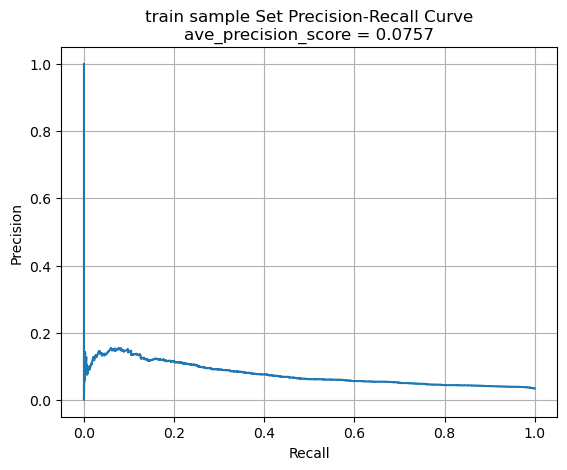

In [10]:
bin_class_utils.eval_class(train_cap_x_df, train_y_df, best_model, "train sample", CVS_SCORING_LIST)

#### 5. Evaluate hyperparameter-tuned estimator on validation set

In [11]:
validation_df = general_utils.read_csv(VALIDATION_FILE_PATH)


Read CSV file ../data/validation_df.csv into DataFrame:
df.head(): 


,uid,task_id,adv_id,creat_type_cd,adv_prim_id,dev_id,inter_type_cd,slot_id,spread_app_id,tags,...,device_price,up_life_duration,up_membership_grade,membership_life_duration,consume_purchase,communication_onlinerate,communication_avgonline_30d,indu_name,pt_d,label
0,1451378,2082,3033,7,154,56,5,11,31,40,...,4,20,-1,-1,7,0^1^2^3^4^5^6^7^8^9^10^11^12^13^14^15^16^17^18...,13,17,5,0
1,1619957,1225,4676,7,178,17,5,17,70,39,...,4,20,-1,-1,2,0^1^2^3^4^5^6^7^8^9^10^11^12^13^14^15^16^17^18...,13,36,6,0
2,1698084,2206,2822,7,177,56,5,14,31,40,...,5,20,1,-1,2,-1,-1,17,3,0
3,1983802,5103,2564,7,151,60,4,12,23,26,...,4,20,-1,-1,8,7^8^9^10^11^12^13^14^15^16^17^18^19^20^21^22^23,10,39,5,0
4,1537560,1098,1732,7,134,55,4,17,65,18,...,4,20,-1,-1,2,3^4^5^6^7^8^9^10^11^12^13^14^15^16^17^18^19^20...,12,14,1,0


df.shape: (167629, 36)


In [12]:
validation_df_sample = data_prepare_utils.sample_data(validation_df, SAMPLE_SIZE, SAMPLE_RANDOM_STATE)
del validation_df


Sample 0.05 fraction from DataFrame:
sample_df.shape: (8381, 36)


In [13]:
validation_cap_x_df, validation_y_df = validation_df_sample.drop(columns=TARGET_ATTR), validation_df_sample[[TARGET_ATTR]]
del validation_df_sample

Evaluate the trained estimator performance on validation sample set
Check accuracy score
validation sample set accuracy score: 0.5878773416060136

Check classification report
              precision    recall  f1-score   support

           0       0.98      0.59      0.73      8092
           1       0.05      0.63      0.09       289

    accuracy                           0.59      8381
   macro avg       0.51      0.61      0.41      8381
weighted avg       0.95      0.59      0.71      8381


Check confusion matrix
validation sample set confusion matrix: 
[[4746 3346]
 [ 108  181]]
True Positives =  4746
True Negatives =  181
False Positives(Type I error) =  3346
False Negatives(Type II error) =  108

Check cross validation score

accuracy scores: [0.60047704 0.60560859 0.82935561 0.39856802 0.71420048]
np.mean(scores): 0.6296419478469765
np.std(scores, ddof=1): 0.1595768197905501

precision scores: [0.05263158 0.06231884 0.06818182 0.04501916 0.06952965]
np.mean(scores): 0.059536

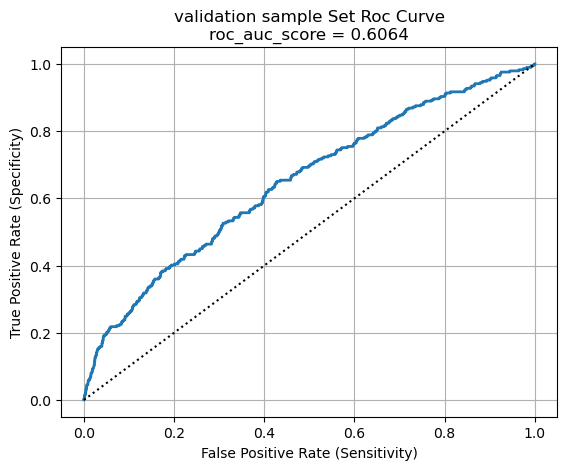


Check Precision-Recall Curve and Average Precision Score


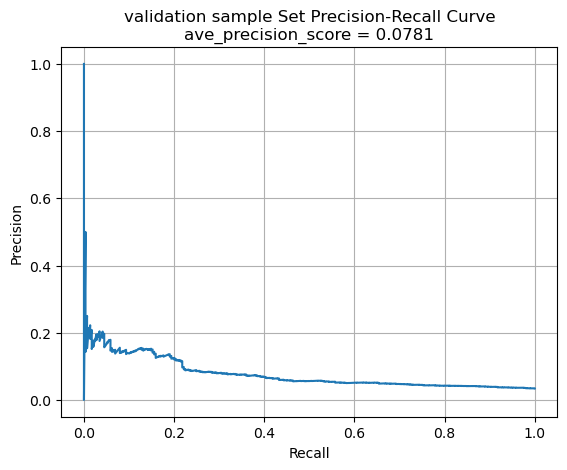

In [14]:
bin_class_utils.eval_class(validation_cap_x_df, validation_y_df, best_model, "validation sample", CVS_SCORING_LIST)

#### 6. Check out permutation feature importance

In [15]:
perm_results_df = bin_class_utils.check_out_permutation_importance(
    best_model, 
    train_cap_x_df, 
    train_y_df, 
    PERMUTATION_IMPORTANCE_RANDOM_STATE,
    PERMUTATION_SCORING_LIST
)
perm_results_df


Check out permutation importance:


,metric_name,feature_name,metric_mean,metric_std_dev
0,average_precision,slot_id,0.021750,0.002107
1,average_precision,age,0.017505,0.001904
2,average_precision,adv_id,0.011763,0.000201
3,average_precision,career,0.004677,0.001110
4,average_precision,app_first_class,0.003811,0.000677
5,roc_auc,slot_id,0.061270,0.003402
6,roc_auc,adv_id,0.028069,0.000662
7,roc_auc,age,0.027873,0.003292
8,roc_auc,app_first_class,0.012445,0.001416


#### 7. Check for False Discoveries


**************************************************
means of the distributions:
                          ave_precision_score
distribution                                 
bootstrap_sample                     0.653382
randomized_target_sample             0.504363


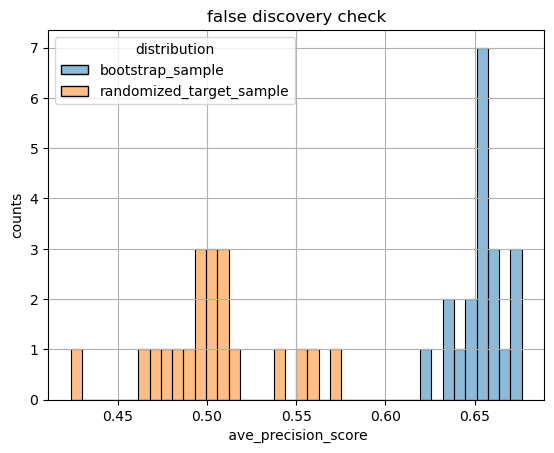


**************************************************
means of the distributions:
                          roc_auc_score_
distribution                            
bootstrap_sample                0.071417
randomized_target_sample        0.036251


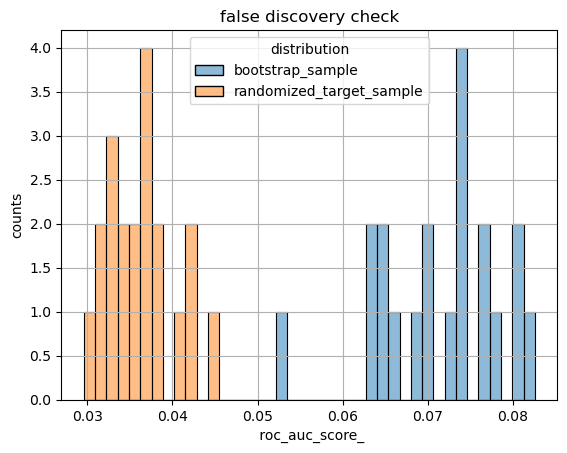

In [16]:
bin_class_utils.avoiding_false_discoveries_class_helper(best_model, train_cap_x_df, train_y_df, validation_cap_x_df,
                                            validation_y_df, num_samples=20)

#### 8. Selection a Model

#### 9. Tune classification threshold for classification - assess threshold list

In [24]:
thresholds = np.arange(0, 0.5, 0.05)

bin_class_utils.print_classification_metrics_at_thresholds(best_model, validation_cap_x_df, validation_y_df, thresholds)


Classification Report at Threshold 0.00:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      8092
           1       0.03      1.00      0.07       289

    accuracy                           0.03      8381
   macro avg       0.02      0.50      0.03      8381
weighted avg       0.00      0.03      0.00      8381


Classification Report at Threshold 0.05:

              precision    recall  f1-score   support

           0       0.91      0.00      0.00      8092
           1       0.03      1.00      0.07       289

    accuracy                           0.04      8381
   macro avg       0.47      0.50      0.03      8381
weighted avg       0.88      0.04      0.00      8381


Classification Report at Threshold 0.10:

              precision    recall  f1-score   support

           0       0.97      0.00      0.01      8092
           1       0.03      1.00      0.07       289

    accuracy                           0.04      8381

C:\Users\Penny\anaconda3\envs\base_dsv5\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Penny\anaconda3\envs\base_dsv5\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Penny\anaconda3\envs\base_dsv5\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.97      0.01      0.02      8092
           1       0.03      0.99      0.07       289

    accuracy                           0.04      8381
   macro avg       0.50      0.50      0.04      8381
weighted avg       0.94      0.04      0.02      8381


Classification Report at Threshold 0.30:

              precision    recall  f1-score   support

           0       0.97      0.02      0.04      8092
           1       0.03      0.98      0.07       289

    accuracy                           0.06      8381
   macro avg       0.50      0.50      0.05      8381
weighted avg       0.94      0.06      0.04      8381


Classification Report at Threshold 0.35:

              precision    recall  f1-score   support

           0       0.98      0.04      0.08      8092
           1       0.04      0.97      0.07       289

    accuracy                           0.08      8381
   macro avg       0.51      0.51      0.0

#### 10. Get the best classification threshold

#### 11. Evaluate the best classification threshold on validation set

#### 12. Evaluate the best model and the best threshold on the test set